In [1]:
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from IPython.display import display
import random

In [2]:
device = "cuda"if torch.cuda.is_available() else "cpu"
print("Device using:", device)

Device using: cuda


In [3]:
class PetClassificationCNN(nn.Module):
    def __init__(self,input_size=1,output_size=3,kernel=3,stride=2,padding=1):
        super(PetClassificationCNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size,out_channels=32,kernel_size=kernel,stride=stride,padding=padding)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=kernel,stride=stride)
        self.dp1 = nn.Dropout(p=0.5)

        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=kernel,stride=stride,padding=padding)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=kernel,stride=stride)
        self.dp2 = nn.Dropout(p=0.5)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=16,kernel_size=kernel,stride=stride,padding=padding)
        self.bn3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=kernel,stride=stride)
        self.dp3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(144, 512)
        self.relu4 = nn.ReLU(inplace=True) 

        self.dp4 = nn.Dropout(p=0.5)
        
        self.fc5 = nn.Linear(512, output_size)
    
    def forward(self,x):
        # print('check')
        x=self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x=self.dp1(x)
        x=self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x=self.dp2(x)
        x=self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x=self.dp3(x)
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc4(x))  # fc9 + relu
        x = self.dp4(x)  # dropout10
        return self.fc5(x)

In [4]:
model = PetClassificationCNN(3,3).to(device=device)
model.load_state_dict(torch.load('DCWreg_Best_CNN.pth',weights_only=False))
model.eval()
BASE_DIR = os.path.abspath(os.getcwd())
BASE_DIR

'd:\\year 3\\hk2\\Machine Learning\\testcode\\DogCatWildRegcon'

In [5]:
rnd_images = []
for phase in os.listdir(os.path.join(BASE_DIR,"afhq")):
    phase_path = os.path.join(os.path.join(BASE_DIR,"afhq"),phase)
    for label in os.listdir(phase_path):
            label_path = os.path.join(phase_path,label)
            rnd_image = os.listdir(label_path)[random.randint(0,len(os.listdir(label_path))-1)]
            rnd_image_path = os.path.join(label_path,rnd_image)
            image = Image.open(rnd_image_path)
            rnd_images.append(image)
            # display(image)


In [6]:
def preprocess_Image(image,transform=None):
    if transform:
        patch = transform(image)
    patch_tensor = torch.tensor(np.array(patch),dtype = torch.float32, device=device)
    return patch_tensor
def classified_image(input,model):
    input = input.unsqueeze(0)
    with torch.no_grad():
        output = model(input)
        _, predicted = torch.max(output, 1)
        print(output,predicted.item())
        classified_image = 'cat' if predicted.item()==0 else 'dog' if predicted.item()==1 else 'wild'
        print(f"The above image is classified as: {classified_image}")
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    # transforms.CenterCrop(299),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

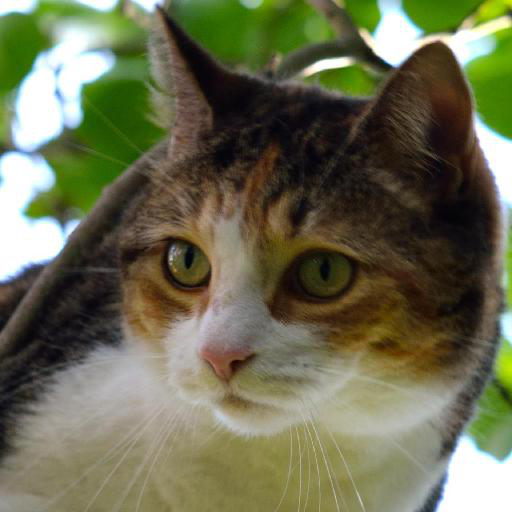

tensor([[ 12.4244,  -6.4817, -10.0058]], device='cuda:0') 0
The above image is classified as: cat


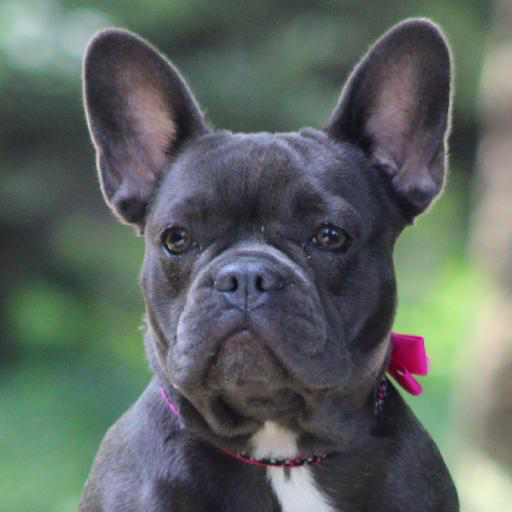

tensor([[-3.2162,  3.3886, -2.0524]], device='cuda:0') 1
The above image is classified as: dog


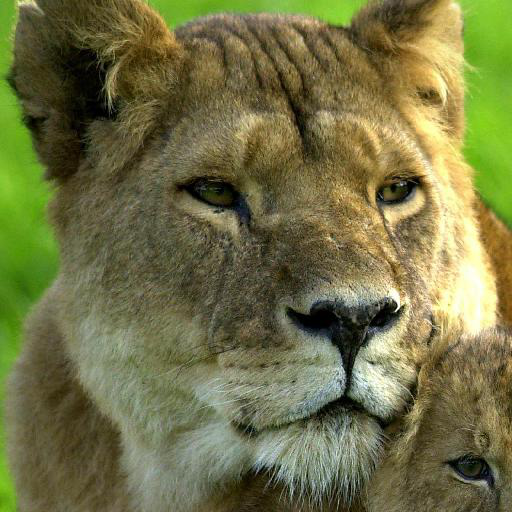

tensor([[-3.7922, -2.7841,  6.4868]], device='cuda:0') 2
The above image is classified as: wild


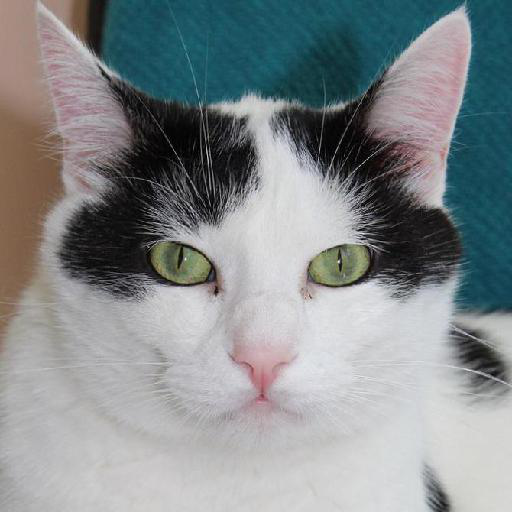

tensor([[ 16.3314,  -6.2157, -15.0528]], device='cuda:0') 0
The above image is classified as: cat


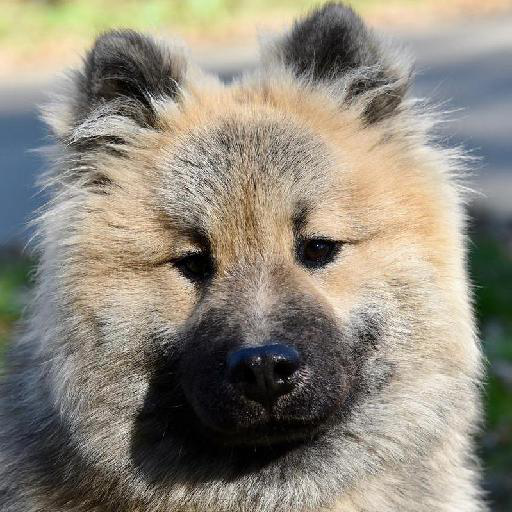

tensor([[-10.5735,   5.5951,   2.2811]], device='cuda:0') 1
The above image is classified as: dog


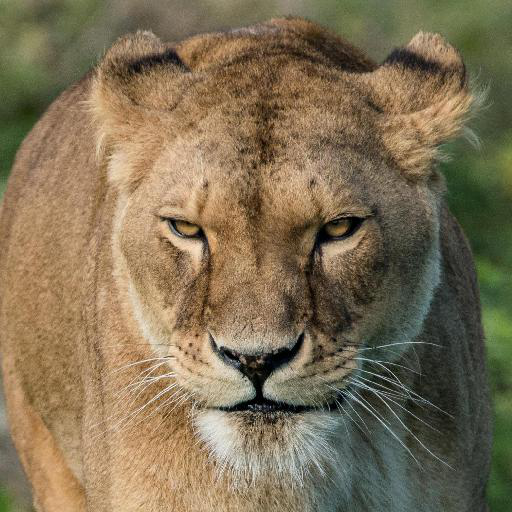

tensor([[-2.5777,  0.0981,  2.6727]], device='cuda:0') 2
The above image is classified as: wild


In [7]:
for image in rnd_images:
    display(image)
    img_tensor = preprocess_Image(image,transform)
    classified_image(img_tensor,model)